<center>
    
    COMP4240/5435 - Reinforcement Learning
    
# Homework 5 - Temporal Difference

    
</center>

Student Name: __Harshal Dafade__ 

The purpose of this project is to study different properties of Temporal Difference methods.  

**General Notes:**
- Questions marked with * are optional for COMP4240 - Undergraduate section. However, students in COMP4240 can gain some extra credits by solving the last part. Questions marked as extra credit are optional for everyone. 
- Do not use a mix of python lists and numpy arrays. Every vector or matrix in your code should be a numpy array. 
- For functions that exist in both the python core and the numpy library, use the one in the numpy library. For example, use `np.max` instead of `max`. Another example: use `np.random.normal` instead of `random.gauss`.
- Make sure all of your plots have a proper size and include `xlabel`, `ylabel`, `legend`, `title`, and `grid`.

In [2]:
# You are allowed to use the following modules
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


## Using Cliff Walking from gym

**Description**

The board is a 4x12 matrix, with (using NumPy matrix indexing):

- `[3, 0]` as the start at bottom-left
- `[3, 11]` as the goal at bottom-right
- `[3, 1..10]` as the cliff at bottom-center

If the agent steps on the cliff, it returns to the start. An episode terminates when the agent reaches the goal.
Actions

**Action**

There are 4 discrete deterministic actions:

- 0: move up
- 1: move right
- 2: move down
- 3: move left

**Observations**

There are 3x12 + 1 possible states. In fact, the agent cannot be at the cliff, nor at the goal (as this results in the end of the episode). It remains all the positions of the first 3 rows plus the bottom-left cell. The observation is simply the current position encoded as flattened index.

**Reward**

Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward.

**Setting the environment**


In [3]:
env = gym.make('CliffWalking-v0')

#or if you get a warning use this instead 

# env = gym.make('CliffWalking-v0', new_step_api=True)

observation, info = env.reset()
print(f'initial state: {observation}')
for _ in range(5):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print(f'action: {action}, next_state: {observation}, reward: {reward}')

env.close()

initial state: 36
action: 1, next_state: 36, reward: -100
action: 0, next_state: 24, reward: -1
action: 1, next_state: 25, reward: -1
action: 3, next_state: 24, reward: -1
action: 0, next_state: 12, reward: -1


## Part I

**(a)** Implement SARSA (on-policy TD control) using $\varepsilon$–greedy policy with parameters $\varepsilon=0.1$ and $Q_0 (s,a)=0$ for all $s,a$. Apply your implementation to the undiscounted cliff walking task for 50 independent runs where each run includes 500 episodes. For the last episode use `render_mode='human'` to watch the agent's learned behavior. You do not need to include this in the report. However, this is a good way of checking on the agent's learning progress a few times during the learning process. (20)


**(b)** Implement Q-learning (off-policy TD control) using $\varepsilon$–greedy policy with parameters $\varepsilon=0.1$ and $Q_0 (s,a)=0$ for all $s,a$. Apply your implementation to the undiscounted cliff walking task. Apply your implementation to the undiscounted cliff walking task for 50 independent runs where each run includes 500 episodes. For the last episode use `render_mode='human'` to watch the agent's learned behavior. You do not need to include this in the report. However, this is a good way of checking on the agent's learning progress a few times during the learning process. (20)


**(c)** Make sure both algorithms use the same parameters (e.g., $\varepsilon$, $\alpha$). Plot sum of rewards during episode over the number of episodes for both algorithms by averaging the results over the 50 runs. Both plots should be shown in one figure for comparison. (5+5,10)


**(d)** Print the optimal policy for each algorithm. This should be a matrix of size 4x12 with elements indicating optimal actions (either use 'U', 'D', 'R', 'L' or print corresponding arrows). (10)


**(e)** Re-run the whole experiment, this time by using a decaying $\varepsilon$. Plot sum of rewards during espisode over the number of episodes. Print the optimal policies. (10+5+5)

You might use the following structure for your code, but feel free to improve upon it by adding more functions, create classes, etc.


In [4]:
#--- Your code here ---#
def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.rand() > epsilon: 
        max_actions = np.flatnonzero(Q[state] == Q[state].max())  # Find all actions with the max Q-value
        return np.random.choice(max_actions)  # Choose randomly among them to break ties
    else:  
        return np.random.choice(nA)  # Explore

        
def sarsa(env, num_episodes=500, alpha=0.1, gamma=1, epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n)) 
    rewards_per_episode = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)
        total_rewards = 0

        done = False
        while not done:
            next_state, reward, done, truncated, _ = env.step(action)
            next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
            
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            
            state = next_state
            action = next_action
            total_rewards += reward
            
        rewards_per_episode.append(total_rewards)
    
    
    return Q, rewards_per_episode


In [5]:
#--- Your code here ---#
def qlearning(env, num_episodes=500, alpha=0.1, gamma=1, epsilon=0.1):

    Q = np.zeros((env.observation_space.n, env.action_space.n)) 
    rewards_per_episode = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_rewards = 0

        done = False
        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)
            next_state, reward, done, truncated, _ = env.step(action)
            
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            
            state = next_state
            total_rewards += reward
            
        rewards_per_episode.append(total_rewards)

    return Q, rewards_per_episode


In [6]:
def print_optimal_policy(Q):
    action_mapping = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    
    optimal_policy = np.empty((4, 12), dtype=str)
    
    for state in range(Q.shape[0]):
        row = state // 12
        col = state % 12
        best_action = np.argmax(Q[state])
        optimal_policy[row, col] = action_mapping[best_action]
    
    for row in optimal_policy:
        print(' '.join(row))

In [7]:
#--- Your code here ---#
def plot_results(sarsa_rewards, qlearning_rewards):
    episodes = len(sarsa_rewards[0])
    avg_sarsa_rewards = np.mean(sarsa_rewards, axis=0)
    avg_qlearning_rewards = np.mean(qlearning_rewards, axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(avg_sarsa_rewards, label='SARSA')
    plt.plot(avg_qlearning_rewards, label='Q-learning')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes for SARSA and Q-learning')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(avg_sarsa_rewards[300:], label='SARSA')
    plt.plot(avg_qlearning_rewards[300:], label='Q-learning')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes 300 to 500 for SARSA and Q-learning')
    plt.legend()
    plt.grid(True)
    plt.show()


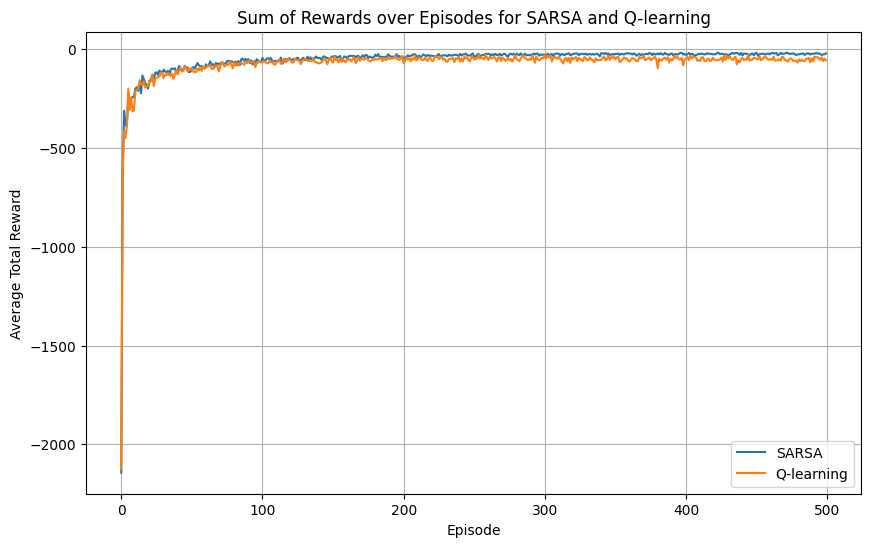

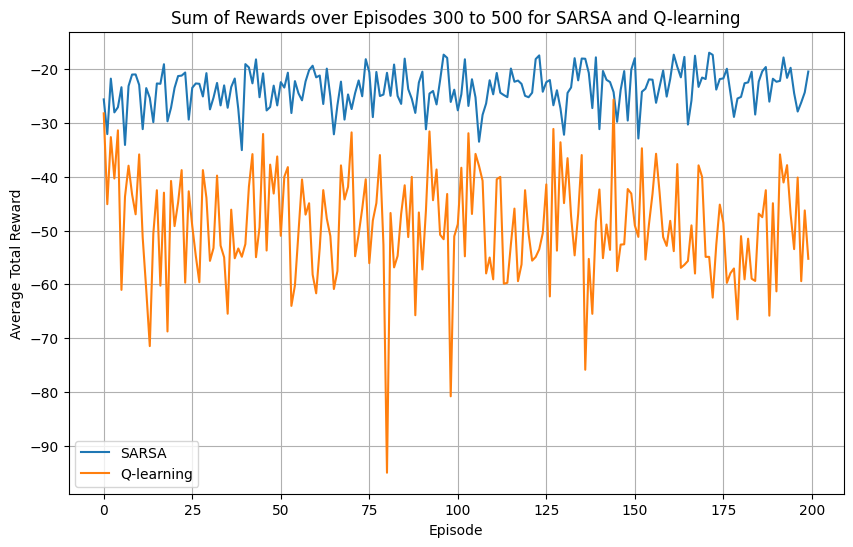

Optimal Policy (SARSA):
R R R U R R R R R R D D
R R R R R R R R R R R D
U U U U L R U U L L R D
U U U U U U U U U U U U

Optimal Policy (Q-learning):
U R D R U R U R U D D D
R R R R R R R L R D D D
R R R R R R R R R R R D
U U U U U U U U U U U U


In [8]:
#--- Your code here ---#
def run_experiments():
    env = gym.make('CliffWalking-v0')
    num_runs = 50
    num_episodes = 500
    
    sarsa_rewards = []
    qlearning_rewards = []
    final_q_sarsa = None
    final_q_qlearning = None
    
    for _ in range(num_runs):
        Q_sarsa, s_rewards = sarsa(env, num_episodes=num_episodes)
        Q_qlearning, q_rewards = qlearning(env, num_episodes=num_episodes)
        
        sarsa_rewards.append(s_rewards)
        qlearning_rewards.append(q_rewards)
        
        final_q_sarsa = Q_sarsa
        final_q_qlearning = Q_qlearning
    
    plot_results(sarsa_rewards, qlearning_rewards)
    print("Optimal Policy (SARSA):")
    print_optimal_policy(final_q_sarsa)

    print("\nOptimal Policy (Q-learning):")
    print_optimal_policy(final_q_qlearning)
    

run_experiments()




In [9]:

def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.rand() > epsilon: 
        max_actions = np.flatnonzero(Q[state] == Q[state].max())  # Find all actions with the max Q-value
        return np.random.choice(max_actions)  # Choose randomly among them to break ties
    else:  
        return np.random.choice(nA)  # Explore

def sarsa_decay(env, num_episodes=500, alpha=0.1, gamma=1.0, epsilon_start=1.0, epsilon_min=0.1, decay_factor=0.99):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_per_episode = []
    
    for episode in range(num_episodes):
        epsilon = max(epsilon_min, epsilon_start * (decay_factor ** episode))
        state, _ = env.reset()
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)
        total_rewards = 0

        done = False
        while not done:
            next_state, reward, done, truncated, _ = env.step(action)
            next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            state = next_state
            action = next_action
            total_rewards += reward
            
        rewards_per_episode.append(total_rewards)
    
    return Q, rewards_per_episode


def qlearning_decay(env, num_episodes=500, alpha=0.1, gamma=1.0, epsilon_start=1.0, epsilon_min=0.1, decay_factor=0.99):
    Q = np.zeros((env.observation_space.n, env.action_space.n)) 
    rewards_per_episode = []

    for episode in range(num_episodes):
        epsilon = max(epsilon_min, epsilon_start * (decay_factor ** episode))
        state, _ = env.reset()
        total_rewards = 0

        done = False
        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)
            next_state, reward, done, truncated, _ = env.step(action)
            
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            
            state = next_state
            total_rewards += reward
            
        rewards_per_episode.append(total_rewards)
    
    return Q, rewards_per_episode


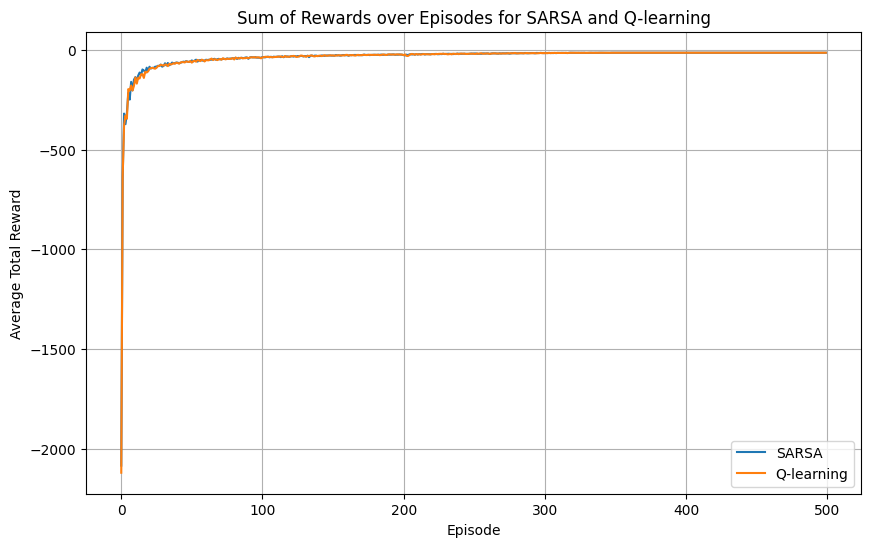

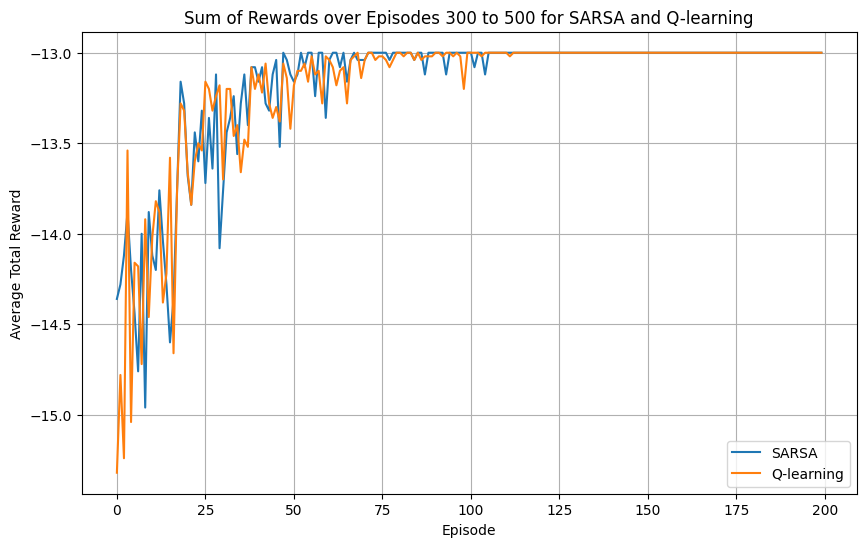

Optimal Policy (SARSA with Decaying Epsilon):
L D R U L U R R R R D D
U R R R R R R D R R R D
R R R R R R R R R R R D
U U U U U U U U U U U U

Optimal Policy (Q-learning with Decaying Epsilon):
U R R R R U R R R R R D
U R U R L R L L R U R D
R R R R R R R R R R R D
U U U U U U U U U U U U


In [10]:
def run_experiments_decay():
    env = gym.make('CliffWalking-v0')
    num_runs = 50
    num_episodes = 500
    epsilon_start = 0.1
    epsilon_min = 0
    decay_factor = 0.9
    
    sarsa_rewards_decay = []
    qlearning_rewards_decay = []
    final_q_sarsa_decay = None
    final_q_qlearning_decay = None
    
    for _ in range(num_runs):
        Q_sarsa_decay, s_rewards = sarsa_decay(env, num_episodes=num_episodes, epsilon_start=epsilon_start, epsilon_min=epsilon_min, decay_factor=decay_factor)
        Q_qlearning_decay, q_rewards = qlearning_decay(env, num_episodes=num_episodes, epsilon_start=epsilon_start, epsilon_min=epsilon_min, decay_factor=decay_factor)
        
        sarsa_rewards_decay.append(s_rewards)
        qlearning_rewards_decay.append(q_rewards)
        
        final_q_sarsa_decay = Q_sarsa_decay
        final_q_qlearning_decay = Q_qlearning_decay
    
    plot_results(sarsa_rewards_decay, qlearning_rewards_decay)
    
    print("Optimal Policy (SARSA with Decaying Epsilon):")
    print_optimal_policy(final_q_sarsa_decay)

    print("\nOptimal Policy (Q-learning with Decaying Epsilon):")
    print_optimal_policy(final_q_qlearning_decay)
    
run_experiments_decay()





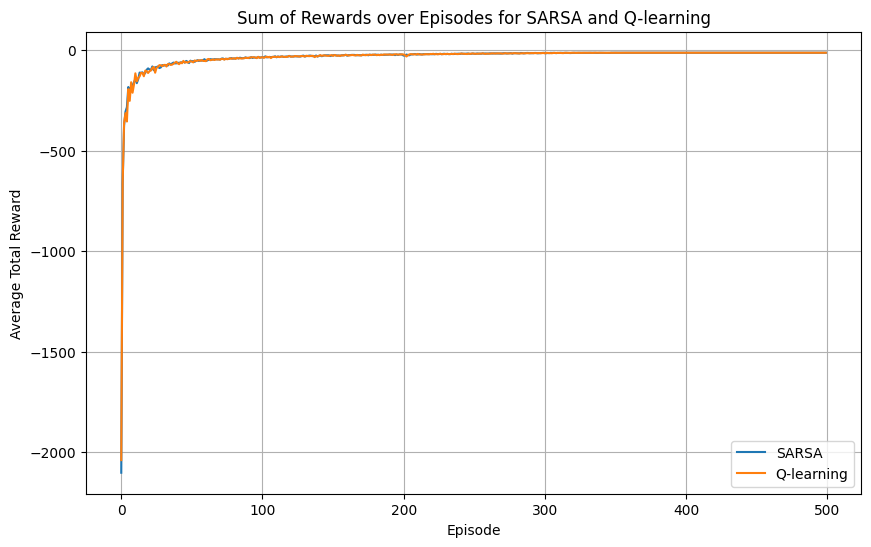

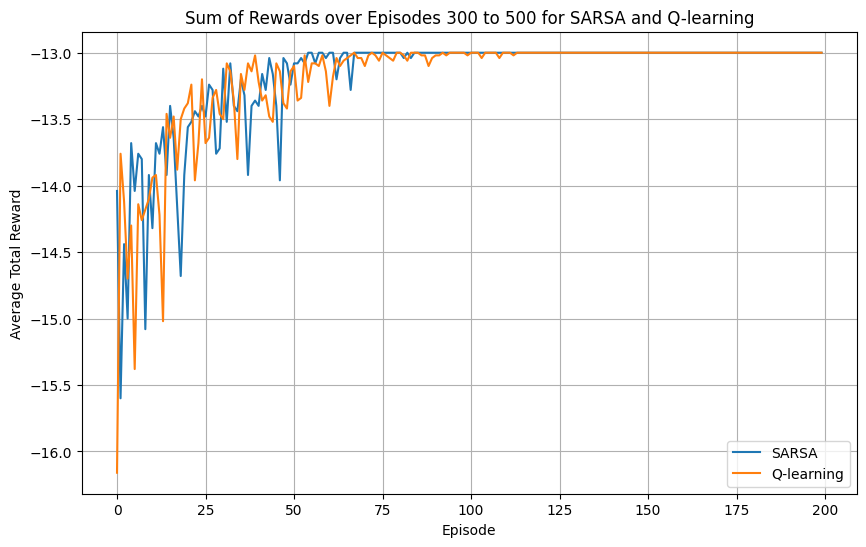

Optimal Policy (SARSA with Decaying Epsilon):
L R R R R R U R R D R D
R D R R R D R R R R R D
R R R R R R R R R R R D
U U U U U U U U U U U U

Optimal Policy (Q-learning with Decaying Epsilon):
R L R L U R R R R R R D
L R U R R R R U R R R D
R R R R R R R R R R R D
U U U U U U U U U U U U


In [13]:
def run_experiments_decay():
    env = gym.make('CliffWalking-v0')
    num_runs = 50
    num_episodes = 500
    epsilon_start = 0.1
    epsilon_min = 0
    decay_factor = 0.9

    sarsa_rewards_decay = []
    qlearning_rewards_decay = []
    final_q_sarsa_decay = None
    final_q_qlearning_decay = None

    for _ in range(num_runs):
        Q_sarsa_decay, s_rewards = sarsa_decay(env, num_episodes=num_episodes, epsilon_start=epsilon_start, epsilon_min=epsilon_min, decay_factor=decay_factor)
        Q_qlearning_decay, q_rewards = qlearning_decay(env, num_episodes=num_episodes, epsilon_start=epsilon_start, epsilon_min=epsilon_min, decay_factor=decay_factor)

        sarsa_rewards_decay.append(s_rewards)
        qlearning_rewards_decay.append(q_rewards)

        final_q_sarsa_decay = Q_sarsa_decay
        final_q_qlearning_decay = Q_qlearning_decay

    plot_results(sarsa_rewards_decay, qlearning_rewards_decay)

    print("Optimal Policy (SARSA with Decaying Epsilon):")
    print_optimal_policy(final_q_sarsa_decay)

    print("\nOptimal Policy (Q-learning with Decaying Epsilon):")
    print_optimal_policy(final_q_qlearning_decay)

    # Render the last episode to watch the agent's behavior
    env = gym.make('CliffWalking-v0', render_mode='human')  # Set render_mode to 'human'
    state, _ = env.reset()
    
    for _ in range(num_episodes):
        action = np.argmax(final_q_sarsa_decay[state])  # or final_q_qlearning_decay[state] for Q-learning
        state, reward, done, _, _ = env.step(action)
        env.render()  # Render the environment to see the agent's behavior
        if done:
            break
    
    env.close()  # Close the environment after rendering

run_experiments_decay()


Answer the following questions:

a. What value of $\alpha$ did you pick? Why? (5)
> Answer
I used alpha as 0.1 for this given task as I wanted my model to be stable while also maintaining learning efficiency. As I ran only 500 episodes here. I did not want my model to react to huge penalties like that of a cliff (-100) and then act eratically affecting the policy.


b. How similar the optimal policies get when you use a decaying $\varepsilon$? Why? (5)
> Answer
As the epsilon decays SARSA's policy moves closer to that of Q-learning as probability of making random moves decreases. The dangerous, closer to cliff policy starts performing better as it accumulates better reward as it follows the path of least resistance and also probability to make random exploratory move that would lead to falling down off cliff reduces as epsilon diminishes.



In [104]:
import numpy as np
import matplotlib.pyplot as plt

def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.rand() > epsilon:
        max_actions = np.flatnonzero(Q[state] == Q[state].max())
        return np.random.choice(max_actions)
    else:
        return np.random.choice(nA)

def n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n):
    Q = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-values
    episode_rewards = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        epsilon = max(epsilon_min, epsilon_start * (decay_factor ** episode))  # Epsilon decay
        state, _ = env.reset()  # Reset the environment
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)
        T = np.inf
        t = 0
        tau = 0
        rewards = []
        states = [state]
        actions = [action]
        
        while tau < (T - 1):
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                rewards.append(reward)
                states.append(next_state)
                
                if done:
                    T = t + 1
                else:
                    next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
                    actions.append(next_action)
            
            tau = t - n + 1
            
            if tau >= 0:
                # Calculate G, the n-step return
                G = np.sum([gamma**(i - tau - 1) * rewards[i] for i in range(tau + 1, min(tau + n, T))])
                
                if tau + n < T:
                    G += gamma**n * Q[states[tau + n], actions[tau + n]]
                
                # Update Q-values
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])
            
            t += 1
            state = next_state
            action = next_action if 'next_action' in locals() else action  # Safely assign action

        episode_rewards[episode] = np.sum(rewards)

    return Q, episode_rewards

# Example usage
# Q, rewards = n_step_sarsa(env, num_episodes=500, alpha=0.1, gamma=1.0, epsilon_start=1.0, epsilon_min=0.1, decay_factor=0.99, n=3)


In [128]:
import numpy as np

def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.rand() > epsilon:
        max_actions = np.flatnonzero(Q[state] == Q[state].max())
        return np.random.choice(max_actions)
    else:
        return np.random.choice(nA)

def n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n):
    Q = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-values
    episode_rewards = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        epsilon = max(epsilon_min, epsilon_start * (decay_factor ** episode))  # Epsilon decay
        state, _ = env.reset()  # Reset the environment
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)

        T = np.inf  # Initialize T to infinity
        t = 0  # Initialize time step
        tau = 0  # Initialize tau
        rewards = []  # Store rewards
        states = [state]  # Store states
        actions = [action]  # Store actions

        while tau < (T - 1):
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                rewards.append(reward)
                states.append(next_state)

                if done:
                    T = t + 1  # Set T to the current time if terminal
                else:
                    next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
                    actions.append(next_action)

            tau = t - n + 1  # Update tau

            if tau >= 0:
                # Calculate the n-step return G
                G = np.sum([gamma**(i - tau - 1) * rewards[i] for i in range(tau + 1, min(tau + n, T))])

                if tau + n < T:
                    G += gamma**n * Q[states[tau + n], actions[tau + n]]

                # Update Q-values
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

            t += 1  # Increment time
            state = next_state  # Update state
            action = next_action if 'next_action' in locals() else action  # Safely assign action

        episode_rewards[episode] = np.sum(rewards)  # Store total rewards for the episode

    return Q, episode_rewards

# Example usage
# Q, rewards = n_step_sarsa(env, num_episodes=500, alpha=0.1, gamma=1.0, epsilon_start=1.0, epsilon_min=0.1, decay_factor=0.99, n=3)


In [148]:
import numpy as np

def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.rand() > epsilon:
        max_actions = np.flatnonzero(Q[state] == Q[state].max())
        return np.random.choice(max_actions)
    else:
        return np.random.choice(nA)

def n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n):
    Q = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-values
    episode_rewards = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        epsilon = max(epsilon_min, epsilon_start * (decay_factor ** episode))  # Epsilon decay
        state, _ = env.reset()  # Reset the environment
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)

        T = np.inf  # Initialize T to infinity
        t = 0  # Initialize time step
        tau = 0  # Initialize tau
        rewards = []  # Store rewards
        states = [state]  # Store states
        actions = [action]  # Store actions

        while tau < (T - 1):
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                rewards.append(reward)
                states.append(next_state)

                if done:
                    T = t + 1  # Set T to the current time if terminal
                else:
                    next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
                    actions.append(next_action)

            tau = t - n + 1  # Update tau

            if tau >= 0:
                # Calculate the n-step return G
                G = np.sum([gamma**(i - tau - 1) * rewards[i] for i in range(tau + 1, min(tau + n, T))])

                if tau + n < T:
                    G += gamma**n * Q[states[tau + n], actions[tau + n]]

                # Update Q-values
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

            t += 1  # Increment time
            state = next_state  # Update state
            action = next_action if 'next_action' in locals() else action  # Safely assign action

        episode_rewards[episode] = np.sum(rewards)  # Store total rewards for the episode

    return Q, episode_rewards


In [335]:
#mast chal rha hai
import numpy as np

def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.rand() > epsilon:
        max_actions = np.flatnonzero(Q[state] == Q[state].max())
        return np.random.choice(max_actions)
    else:
        return np.random.choice(nA)

def n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n):
    Q = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-values
    episode_rewards = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        epsilon = max(epsilon_min, epsilon_start * (decay_factor ** episode))  # Epsilon decay
        state, _ = env.reset()  # Reset the environment
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)

        T = np.inf  # Initialize T to infinity
        t = 0  # Initialize time step
        tau = 0  # Initialize tau
        rewards = []  # Store rewards
        states = [state]  # Store states
        actions = [action]  # Store actions

        while tau < (T - 1):
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                rewards.append(reward)
                states.append(next_state)

                if done:
                    T = t + 1  # Set T to the current time if terminal
                else:
                    next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
                    actions.append(next_action)

            tau = t - n + 1  # Update tau

            if tau >= 0:
                if n == 1:  # Handle zero-step SARSA
                    # Update Q-value immediately with the reward and estimated value of the next state
                    Q[states[tau], actions[tau]] += alpha * (rewards[tau] + gamma * Q[next_state].max() - Q[states[tau], actions[tau]])
                else:
                    # Calculate the n-step return G for n > 1
                    G = np.sum([gamma**(i - tau - 1) * rewards[i] for i in range(tau + 1, min(tau + n, T))])
                    if tau + n < T:
                        G += gamma**n * Q[states[tau + n], actions[tau + n]]
                    # Update Q-values
                    Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

            t += 1  # Increment time
            state = next_state  # Update state
            action = next_action if 'next_action' in locals() else action  # Safely assign action

        episode_rewards[episode] = np.sum(rewards)  # Store total rewards for the episode

    return Q, episode_rewards

# Example usage for zero-step SARSA (n=1)
# Q, rewards = n_step_sarsa(env, num_episodes=500, alpha=0.1, gamma=1.0, epsilon_start=1.0, epsilon_min=0.1, decay_factor=0.99, n=1)


In [319]:
import numpy as np

def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.rand() > epsilon:
        max_actions = np.flatnonzero(Q[state] == Q[state].max())
        return np.random.choice(max_actions)
    else:
        return np.random.choice(nA)

def n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n):
    Q = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-values
    episode_rewards = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        epsilon = max(epsilon_min, epsilon_start * (decay_factor ** episode))  # Epsilon decay
        state, _ = env.reset()  # Reset the environment
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)

        T = np.inf  # Initialize T to infinity
        t = 0  # Initialize time step
        tau = 0  # Initialize tau
        rewards = []  # Store rewards
        states = [state]  # Store states
        actions = [action]  # Store actions

        while tau < (T - 1):
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                rewards.append(reward)
                states.append(next_state)

                if done:
                    T = t + 1  # Set T to the current time if terminal
                else:
                    next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
                    actions.append(next_action)

            tau = t - n + 1  # Update tau

            if tau >= 0:
                # Calculate the n-step return G
                G = np.sum([gamma**(i - tau - 1) * rewards[i] for i in range(tau + 1, min(tau + n, T))])

                if tau + n < T:
                    # Use the action taken in the next state, not just the max Q-value
                    G += gamma**n * Q[states[tau + n], actions[tau + n]]

                # Update Q-values using the action taken in the next state
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

            t += 1  # Increment time
            state = next_state  # Update state
            action = next_action if 'next_action' in locals() else action  # Safely assign action

        episode_rewards[episode] = np.sum(rewards)  # Store total rewards for the episode

    return Q, episode_rewards

# Example usage for n-step SARSA where n = 1 behaves like SARSA
# Q, rewards = n_step_sarsa(env, num_episodes=500, alpha=0.1, gamma=1.0, epsilon_start=1.0, epsilon_min=0.1, decay_factor=0.99, n=1)


In [328]:
import numpy as np

def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.rand() > epsilon:
        max_actions = np.flatnonzero(Q[state] == Q[state].max())
        return np.random.choice(max_actions)
    else:
        return np.random.choice(nA)

def n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n):
    Q = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-values
    episode_rewards = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        epsilon = max(epsilon_min, epsilon_start * (decay_factor ** episode))  # Epsilon decay
        state, _ = env.reset()  # Reset the environment
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)

        T = np.inf  # Initialize T to infinity
        t = 0  # Initialize time step
        tau = 0  # Initialize tau
        rewards = []  # Store rewards
        states = [state]  # Store states
        actions = [action]  # Store actions

        while tau < (T - 1):
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                rewards.append(reward)
                states.append(next_state)

                if done:
                    T = t + 1  # Set T to the current time if terminal
                else:
                    action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
                    actions.append(action)

            tau = t - n + 1  # Update tau

            if tau >= 0:
                # Calculate the n-step return G
                G = np.sum([gamma ** (i - tau - 1) * rewards[i] for i in range(tau + 1, min(tau + n, T))])

                if tau + n < T:
                    G += gamma ** n * Q[states[tau + n], actions[tau + n]]  # Add value of the next state-action

                # Update Q-values
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

            t += 1  # Increment time

        episode_rewards[episode] = np.sum(rewards)  # Store total rewards for the episode

    return Q, episode_rewards

# Example usage
# env = gym.make('CliffWalking-v0')
# Q, rewards = n_step_sarsa(env, num_episodes=500, alpha=0.1, gamma=1.0, epsilon_start=1.0, epsilon_min=0.1, decay_factor=0.99, n=3)


In [329]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(nstep_rewards):
    episodes = len(nstep_rewards[0])
    avg_nstep_rewards = np.mean(nstep_rewards, axis=0)  # Average rewards across all runs

    plt.figure(figsize=(10, 6))
    plt.plot(avg_nstep_rewards, label='n-step SARSA', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes for n-step SARSA')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Optional: Zooming in on the later episodes to see performance
    plt.figure(figsize=(10, 6))
    plt.plot(avg_nstep_rewards[300:], label='n-step SARSA', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes 300 to 500 for n-step SARSA')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_optimal_policy(Q):
    action_mapping = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    
    optimal_policy = np.empty((4, 12), dtype=str)
    
    for state in range(Q.shape[0]):
        row = state // 12
        col = state % 12
        best_action = np.argmax(Q[state])
        optimal_policy[row, col] = action_mapping[best_action]
    
    for row in optimal_policy:
        print(' '.join(row))

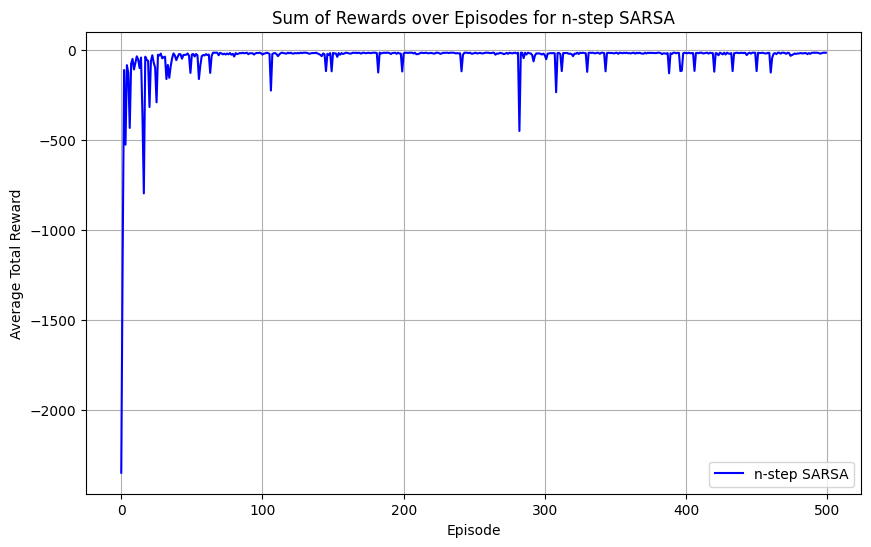

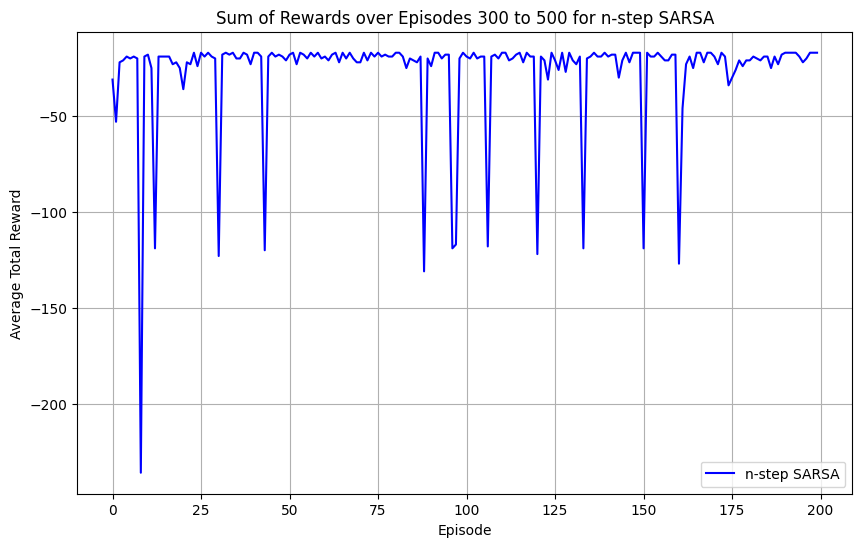

Optimal Policy (n-step SARSA):
R D R R R R R R R R R D
R R R U R R U R R R R D
U U D L D U D D R R R D
U U U U U U U U U U U U


In [330]:
import numpy as np
import gym

def run_experiments_nstep():
    env = gym.make('CliffWalking-v0')
    num_runs = 1
    num_episodes = 500
    n = 2 # Number of steps to consider for n-step SARSA
    alpha = 0.1
    gamma = 0.99
    epsilon_start = 0.1
    epsilon_min = 0.1
    decay_factor = 0.99

    nstep_rewards = []
    final_q_nstep = None

    for _ in range(num_runs):
        Q_nstep, rewards = n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n)
        
        nstep_rewards.append(rewards)
        final_q_nstep = Q_nstep

    plot_results(nstep_rewards)  # Adjust this to handle multiple runs if needed

    print("Optimal Policy (n-step SARSA):")
    print_optimal_policy(final_q_nstep)

    # Render the last episode to watch the agent's behavior
    env = gym.make('CliffWalking-v0', render_mode='human')  # Set render_mode to 'human'
    state, _ = env.reset()
    
    for _ in range(num_episodes):
        action = np.argmax(final_q_nstep[state])  # Use the learned Q-values
        state, reward, done, _, _ = env.step(action)
        env.render()  # Render the environment to see the agent's behavior
        if done:
            break
    
    env.close()  # Close the environment after rendering

# Example of running the modified function
run_experiments_nstep()


In [331]:
pip install pygame


python(91301) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [336]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(nstep_rewards):
    episodes = len(nstep_rewards[0])
    avg_nstep_rewards = np.mean(nstep_rewards, axis=0)  # Average rewards across all runs

    plt.figure(figsize=(10, 6))
    plt.plot(avg_nstep_rewards, label='n-step SARSA', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes for n-step SARSA in Taxi Environment')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Optional: Zooming in on the later episodes to see performance
    plt.figure(figsize=(10, 6))
    plt.plot(avg_nstep_rewards[300:], label='n-step SARSA', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Sum of Rewards over Episodes 300 to 500 for n-step SARSA in Taxi Environment')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_optimal_policy(Q):
    action_mapping = {0: 'S', 1: 'N', 2: 'E', 3: 'W', 4: 'P', 5: 'D'}  # Actions for Taxi environment
    # 0: South, 1: North, 2: East, 3: West, 4: Pick up, 5: Drop off

    print("Optimal Policy (Taxi Position, Passenger Location, Destination):")
    
    # Iterate through each taxi position (5 rows x 5 columns)
    for taxi_row in range(5):
        for taxi_col in range(5):
            for passenger_location in range(5):  # Passenger locations
                for destination in range(4):  # Destination locations
                    # Calculate the state index based on taxi position, passenger location, and destination
                    state_index = (taxi_row * 5 + taxi_col) * 5 * 4 + passenger_location * 4 + destination
                    
                    # Find the best action for this state
                    best_action = np.argmax(Q[state_index])  # Get the best action index
                    action_str = action_mapping[best_action]  # Get the action string
                    
                    # Print the optimal action for the given state
                    print(f"Taxi at ({taxi_row}, {taxi_col}), Passenger Pos: {passenger_location}, Destination: {destination}, Best Action: {action_str}")

# Example usage after training the agent
# print_optimal_policy(final_q_nstep)







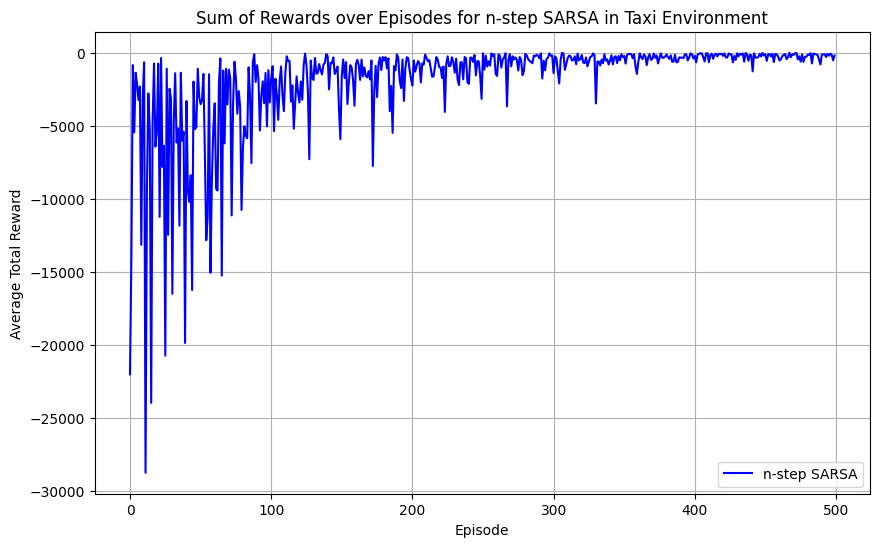

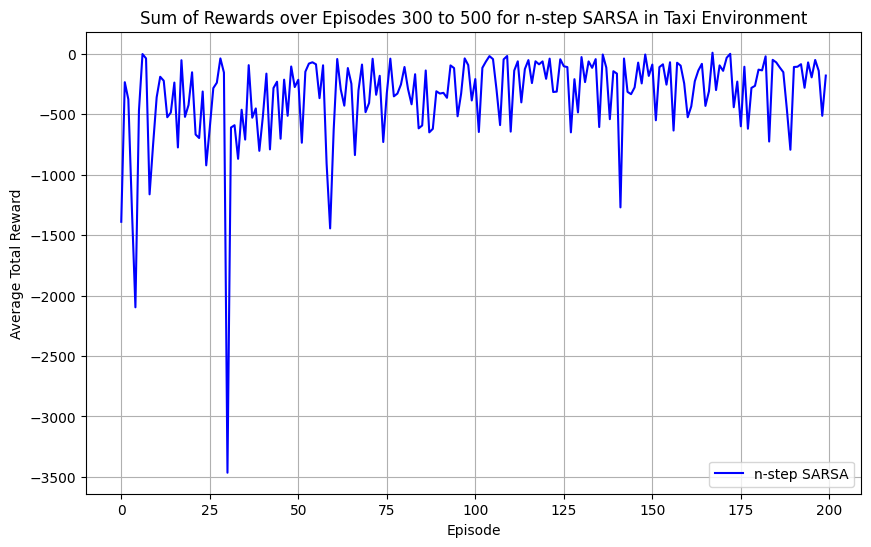

Optimal Policy (n-step SARSA):
Optimal Policy (Taxi Position, Passenger Location, Destination):
Taxi at (0, 0), Passenger Pos: 0, Destination: 0, Best Action: S
Taxi at (0, 0), Passenger Pos: 0, Destination: 1, Best Action: P
Taxi at (0, 0), Passenger Pos: 0, Destination: 2, Best Action: P
Taxi at (0, 0), Passenger Pos: 0, Destination: 3, Best Action: P
Taxi at (0, 0), Passenger Pos: 1, Destination: 0, Best Action: P
Taxi at (0, 0), Passenger Pos: 1, Destination: 1, Best Action: S
Taxi at (0, 0), Passenger Pos: 1, Destination: 2, Best Action: W
Taxi at (0, 0), Passenger Pos: 1, Destination: 3, Best Action: N
Taxi at (0, 0), Passenger Pos: 2, Destination: 0, Best Action: S
Taxi at (0, 0), Passenger Pos: 2, Destination: 1, Best Action: S
Taxi at (0, 0), Passenger Pos: 2, Destination: 2, Best Action: S
Taxi at (0, 0), Passenger Pos: 2, Destination: 3, Best Action: E
Taxi at (0, 0), Passenger Pos: 3, Destination: 0, Best Action: S
Taxi at (0, 0), Passenger Pos: 3, Destination: 1, Best Acti

In [338]:
import numpy as np
import gym
import matplotlib.pyplot as plt

def run_experiments_nstep():
    env = gym.make('Taxi-v3')  # Specify the Taxi environment
    num_runs = 1
    num_episodes = 500
    n = 3  # Number of steps to consider for n-step SARSA
    alpha = 0.1
    gamma = 0.99
    epsilon_start = 1.0  # Start with higher epsilon for exploration
    epsilon_min = 0.1
    decay_factor = 0.999  # Slower decay

    nstep_rewards = []
    final_q_nstep = None

    for _ in range(num_runs):
        Q_nstep, rewards = n_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, decay_factor, n)
        
        nstep_rewards.append(rewards)
        final_q_nstep = Q_nstep

    plot_results(nstep_rewards)  # Plot the results



    # Render the last episode to watch the agent's behavior
    env = gym.make('Taxi-v3', render_mode='human') 
    state, _ = env.reset()  # Reset environment and get initial state

    for _ in range(num_episodes):
        action = np.argmax(final_q_nstep[state])  # Use the learned Q-values
        state, reward, done, truncated, _ = env.step(action)  # Step through the environment
        env.render()  # Render the environment to see the agent's behavior
        if done or truncated:
            break
    
    env.close()  # Close the environment after rendering
    print("Optimal Policy (n-step SARSA):")
    print_optimal_policy(final_q_nstep)

# Example of running the modified function
run_experiments_nstep()
